<a href="https://colab.research.google.com/github/amirkasaei/Decision-Tree-Classifier-with-scikit-learn/blob/main/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Required Libraries**

**install graphviz and pydotplus**

In [1]:
# pip install -q graphviz

In [2]:
# pip install -q pydotplus

**load the required libraries**

In [3]:
# Load libraries
import pandas as pd
import torch
import tensorflow as tf
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns

**set GPU**

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Loading Data**

In [5]:
url = 'https://raw.githubusercontent.com/amirkasaei/Decision-Tree-with-Python/main/Dataset/connect-4.data'

In [6]:
feature_columns = [str(i) for i in range(1, 43)]
column_names = feature_columns + ['class']

In [7]:
df = pd.read_csv(url, names=column_names)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,class
0,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,o,b,b,b,...,b,b,b,b,b,b,b,b,b,win
3,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
4,o,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win


# **Feature Selection**

**encode dataset**

In [8]:
le = LabelEncoder()

df[column_names] = df[column_names].apply(le.fit_transform, axis=0)

In [9]:
classes = le.classes_
classes

array(['draw', 'loss', 'win'], dtype=object)

In [10]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


**divide given columns into two types of variables (target variable and feature variables).**

In [11]:
x = df[column_names[:-1]]
y = df['class']

x.shape, y.shape

((67557, 42), (67557,))

# **Splitting Data**

70% training, 20% validation and 10% test

In [12]:
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [13]:
x_train.shape, x_valid.shape, x_test.shape

((48640, 42), (12161, 42), (6756, 42))

# **Building Decision Tree Model**

create a decision tree model using Scikit-learn

## **helper function**

In [14]:
def plot_confusionmatrix(y_train_pred,y_train,dom):
  print(f'{dom} Confusion matrix')
  cf = confusion_matrix(y_train_pred,y_train)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

## **Pre Pruning (Hyperparameter Tunning)**

### **find best max features**

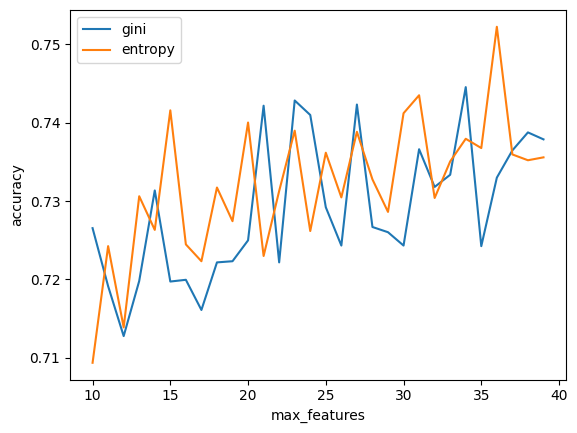

In [41]:
max_features = []
acc_gini = []
acc_entropy = []
start = 10
end = 40
for i in range(start, end):
  # decision tree with gini
  dtree = DecisionTreeClassifier(criterion='gini', max_features=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_gini.append(accuracy_score(y_valid,pred))

  # decision tree with entropy
  dtree = DecisionTreeClassifier(criterion='entropy', max_features=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_entropy.append(accuracy_score(y_valid, pred))

  max_features.append(i)
  d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy), 'max_features':pd.Series(max_features)})# visualizing changes in parameters
plt.plot('max_features','acc_gini', data=d, label='gini')
plt.plot('max_features','acc_entropy', data=d, label='entropy')
plt.xlabel('max_features')
plt.ylabel('accuracy')
plt.legend()

best_ent_max_features = np.argmax(acc_entropy) + 1 + start
best_gini_max_features = np.argmax(acc_gini) + 1 + start

In [42]:
print('best max features for entropy:', best_ent_max_features, '\nbest max features for gini:', best_gini_max_features)

best max features for entropy: 37 
best max features for gini: 35


### **find best max depth**

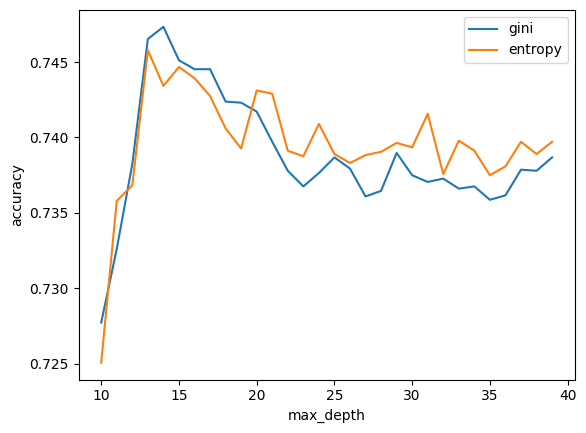

In [43]:
max_depth = []
acc_gini = []
acc_entropy = []
start = 10
end = 40
for i in range(start, end):
  # decision tree with gini
  dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_gini.append(accuracy_score(y_valid,pred))

  # decision tree with entropy
  dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_entropy.append(accuracy_score(y_valid, pred))

  max_depth.append(i)
  d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy), 'max_depth':pd.Series(max_depth)})# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

best_ent_max_depth = np.argmax(acc_entropy) + 1 + start
best_gini_max_depth = np.argmax(acc_gini) + 1 + start

In [44]:
print('best max depth for entropy:', best_ent_max_depth, '\nbest max depth for gini:', best_gini_max_depth)

best max depth for entropy: 14 
best max depth for gini: 15


### **find best min sample split**

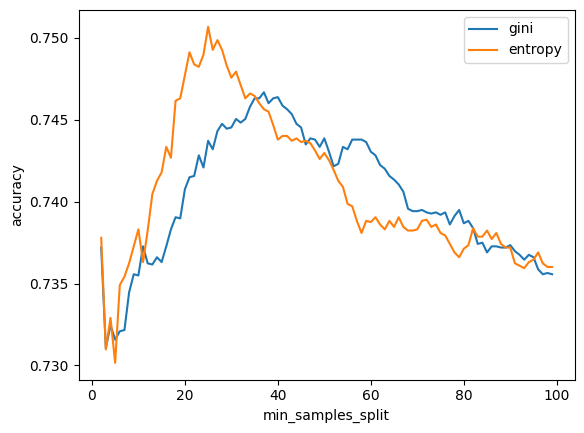

In [45]:
min_samples_split = []
acc_gini = []
acc_entropy = []
start = 2
end = 100
for i in range(start, end):
  # decision tree with gini
  dtree = DecisionTreeClassifier(criterion='gini', min_samples_split=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_test)
  acc_gini.append(accuracy_score(y_test,pred))

  # decision tree with entropy
  dtree = DecisionTreeClassifier(criterion='entropy', min_samples_split=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_test)
  acc_entropy.append(accuracy_score(y_test, pred))

  min_samples_split.append(i)
  d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy), 'min_samples_split':pd.Series(min_samples_split)})# visualizing changes in parameters
plt.plot('min_samples_split','acc_gini', data=d, label='gini')
plt.plot('min_samples_split','acc_entropy', data=d, label='entropy')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.legend()

best_ent_min_samples_split = np.argmax(acc_entropy) + 1 + start
best_gini_min_samples_split = np.argmax(acc_gini) + 1 + start

In [46]:
print('best min samples split for entropy:', best_ent_min_samples_split, '\nbest min samples split for gini:', best_gini_min_samples_split)

best min samples split for entropy: 26 
best min samples split for gini: 38


### **find best min sample leaf**

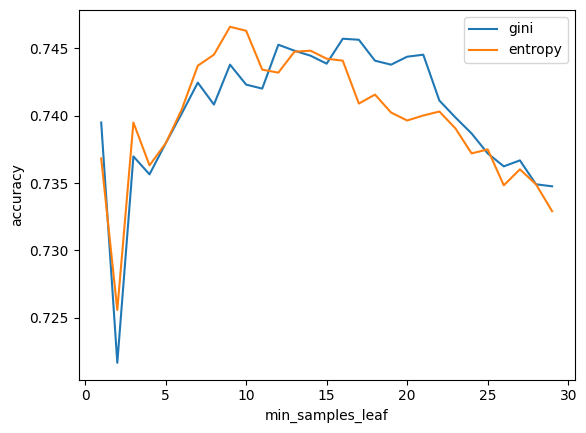

In [47]:
min_samples_leaf = []
acc_gini = []
acc_entropy = []
start = 1
end = 30
for i in range(start, end):
  # decision tree with gini
  dtree = DecisionTreeClassifier(criterion='gini', min_samples_leaf=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_gini.append(accuracy_score(y_valid,pred))

  # decision tree with entropy
  dtree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_entropy.append(accuracy_score(y_valid, pred))

  min_samples_leaf.append(i)
  d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy), 'min_samples_leaf':pd.Series(min_samples_leaf)})# visualizing changes in parameters
plt.plot('min_samples_leaf','acc_gini', data=d, label='gini')
plt.plot('min_samples_leaf','acc_entropy', data=d, label='entropy')
plt.xlabel('min_samples_leaf')
plt.ylabel('accuracy')
plt.legend()

best_ent_min_samples_leaf = np.argmax(acc_entropy) + 1 +start
best_gini_min_samples_leaf = np.argmax(acc_gini) + 1 + start

In [48]:
print('best min samples leaf for entropy:', best_ent_min_samples_leaf, '\nbest min samples leaf for gini:', best_gini_min_samples_leaf)

best mmin samples leaf for entropy: 10 
best min samples leaf for gini: 17


### **find best max leaf nodes**

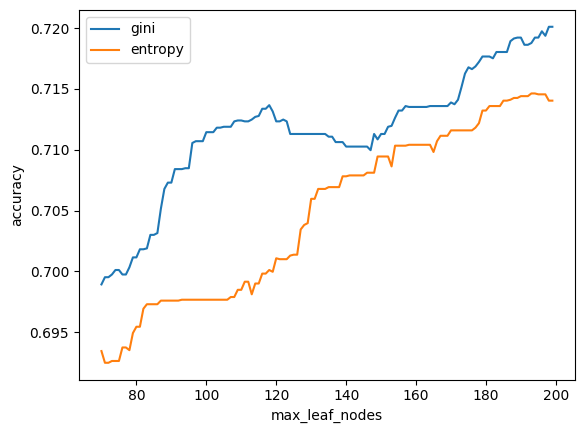

In [49]:
max_leaf_nodes = []
acc_gini = []
acc_entropy = []
start = 70
end = 200
for i in range(start, end):
  # decision tree with gini
  dtree = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_gini.append(accuracy_score(y_valid,pred))

  # decision tree with entropy
  dtree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=i)
  dtree.fit(x_train, y_train)
  pred = dtree.predict(x_valid)
  acc_entropy.append(accuracy_score(y_valid, pred))

  max_leaf_nodes.append(i)
  d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy), 'max_leaf_nodes':pd.Series(max_leaf_nodes)})# visualizing changes in parameters
plt.plot('max_leaf_nodes','acc_gini', data=d, label='gini')
plt.plot('max_leaf_nodes','acc_entropy', data=d, label='entropy')
plt.xlabel('max_leaf_nodes')
plt.ylabel('accuracy')
plt.legend()

best_ent_max_leaf_nodes = np.argmax(acc_entropy) + 1 + start
best_gini_max_leaf_nodes = np.argmax(acc_gini) + 1 + start

In [50]:
print('best max leaf nodes for entropy:', best_ent_max_leaf_nodes, '\nbest max leaf nodes for gini:', best_gini_max_leaf_nodes)

best max leaf nodes for entropy: 194 
best max leaf nodes for gini: 199


### **GridSearchCV**

In [ ]:
params = {
    'max_depth': [10, 12, 13, 14, 15, 16],
    'min_samples_split': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

clf = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 12, 13, 14, 15, 16],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                              15, 16, 17, 18, 19, 20],
                         'min_samples_split': [20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, 32, 33, 34, 35,
                                               36, 37, 38, 39, 40]})

In [ ]:
gcv.best_params_

{'max_depth': 16, 'min_samples_leaf': 7, 'min_samples_split': 32}

In [ ]:
cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.135250,0.007770,0.004632,0.000491,10,5,20,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.721806,0.719956,0.719308,0.727542,0.729392,0.723601,0.004099,1753
1,0.136581,0.008599,0.004991,0.000693,10,5,21,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.721898,0.720048,0.719123,0.727634,0.729485,0.723638,0.004158,1750
2,0.129640,0.001537,0.004551,0.000223,10,5,22,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.721898,0.720233,0.719308,0.727727,0.729485,0.723730,0.004104,1732
3,0.137194,0.009184,0.004390,0.000109,10,5,23,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.721991,0.720696,0.719215,0.727912,0.729577,0.723878,0.004103,1710
4,0.131899,0.002720,0.004500,0.000247,10,5,24,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.721806,0.720881,0.719215,0.728004,0.729577,0.723897,0.004112,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,0.144212,0.001955,0.004635,0.000258,16,20,36,"{'max_depth': 16, 'min_samples_leaf': 20, 'min...",0.736238,0.730687,0.729577,0.731242,0.732075,0.731964,0.002286,1465
2012,0.144443,0.003030,0.004626,0.000131,16,20,37,"{'max_depth': 16, 'min_samples_leaf': 20, 'min...",0.736053,0.730687,0.729577,0.731242,0.732075,0.731927,0.002217,1472
2013,0.146484,0.002607,0.004742,0.000139,16,20,38,"{'max_depth': 16, 'min_samples_leaf': 20, 'min...",0.736053,0.730687,0.729577,0.731242,0.732075,0.731927,0.002217,1472
2014,0.143043,0.001834,0.004591,0.000167,16,20,39,"{'max_depth': 16, 'min_samples_leaf': 20, 'min...",0.736053,0.730687,0.729577,0.731242,0.732075,0.731927,0.002217,1472


In [ ]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

accuracy_score(y_test_pred,y_test)

# print(f'Train score {accuracy_score(y_train_pred,y_train)}')
# print(f'Test score {accuracy_score(y_test_pred,y_test)}')
# plot_confusionmatrix(y_train_pred,y_train,dom='Train')
# plot_confusionmatrix(y_test_pred,y_test,dom='Test')

0.749185908821788

## **Post Prunning**

In [15]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

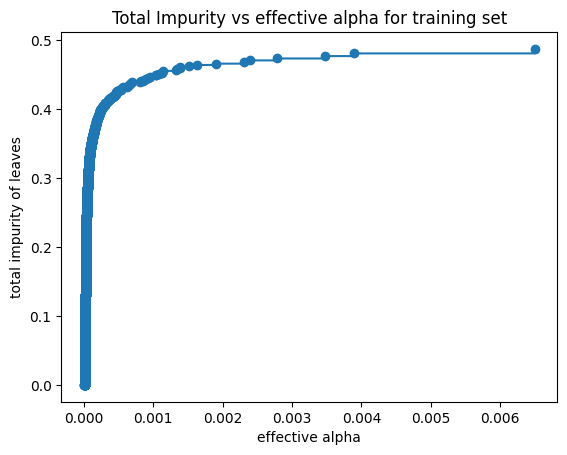

In [16]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [17]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.010977735725869464


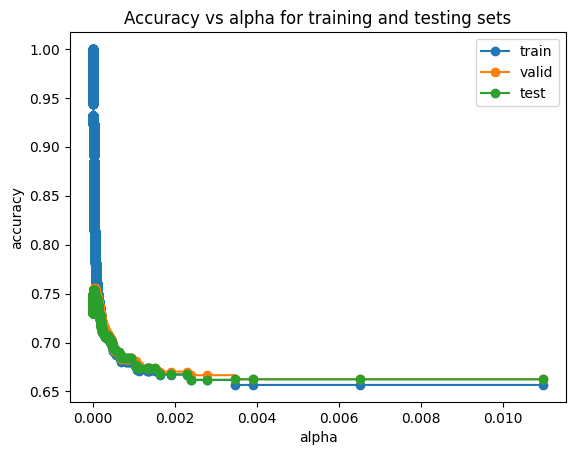

In [20]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
valid_scores = [clf.score(x_valid, y_valid) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker="o", label="valid", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [23]:
ccp_alphas[np.argmax(train_scores)]

0.0

In [21]:
ccp_alphas[np.argmax(valid_scores)]

5.333214411446677e-05

In [22]:
ccp_alphas[np.argmax(test_scores)]

4.083450814536336e-05

## **Models**

### **Informaion Gain (Entropy)**

In [ ]:
# Create Decision Tree classifer object
dtc_ent = DecisionTreeClassifier(criterion='entropy', max_depth=best_ent_max_depth, random_state=0)

In [ ]:
# Train Decision Tree Classifer
dtc_ent = dtc_ent.fit(x_train, y_train)

In [ ]:
# Predict the response for test dataset
y_pred_ent = dtc_ent.predict(x_test)

In [ ]:
ent_path = dtc_ent.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ent_path.ccp_alphas, ent_path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

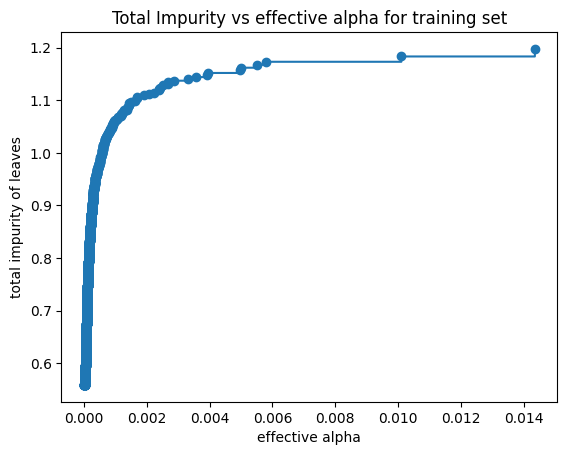

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

### **Gini Index**

In [ ]:
# Create Decision Tree classifer object
dtc_gini = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=10, min_samples_leaf=10, random_state=0)

In [ ]:
# Train Decision Tree Classifer
dtc_gini = dtc_gini.fit(x_train, y_train)

In [ ]:
# Predict the response for test dataset
y_pred_gini = dtc_gini.predict(x_test)
print("Accuracy (gini):", metrics.accuracy_score(y_test, y_pred_gini))

Accuracy (gini): 0.7102575488454707


# **Evaluating the Model**

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy (entropy):", metrics.accuracy_score(y_test, y_pred_ent))

print("Accuracy (gini):", metrics.accuracy_score(y_test, y_pred_gini))


Test score 0.7458555358200119
Test Confusion matrix


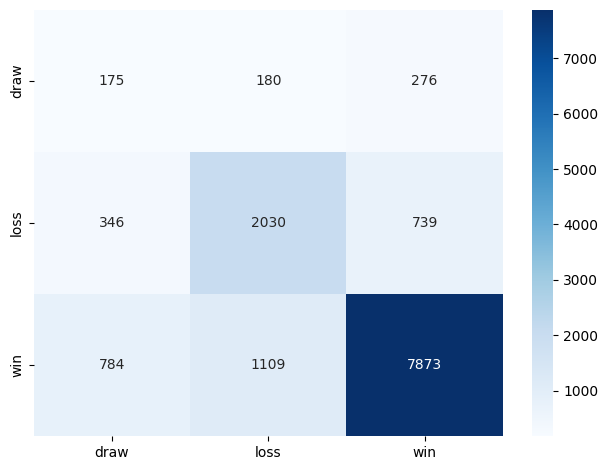

In [ ]:
print(f'Test score {accuracy_score(y_pred_gini,y_test)}')
plot_confusionmatrix(y_pred_gini,y_test,dom='Test')

# **Visualizing Decision Trees**

In [ ]:
with tf.device('/GPU:0'):
  dot_data = StringIO()
  export_graphviz(dtc_ent, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_columns,class_names=classes)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('decisionTreeClassifierEntropy.png')
  Image(graph.create_png())

In [ ]:
dot_data = StringIO()
export_graphviz(dtc_gini, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_columns,class_names=classes)
gini_graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
gini_graph.write_png('decisionTreeClassifierGini.png')
Image(graph.create_png())